# BGPDistinct: Data Experimentation
*Quick notes and graphics on the BGP data and some of its characteristics*

*Author: Andy Dolan*

In [1]:
import json
import matplotlib.pyplot as plt
import sys
from datetime import datetime as dt
import math
import statistics
%matplotlib inline

## Some Example Data
The following lines import some preprocessed data from an original set of over 250,000 BGP messages from a single collector during a single hour on November 1st, 2018. The preprocessing step was responsible for properly formatting the JSON data and filtering out any unwanted or malformed BGP messages.

In [2]:
# Your file here
# filename = ''
with open(filename) as f:
    all_announcements = json.load(f)

In [3]:
print('Total number of announcements in dataset: {:d}'.format(len(all_announcements)))
print(json.dumps(all_announcements[0].get('bgp_update'), indent=2))

Total number of announcements in dataset: 254911
{
  "advertized_routes": [
    {
      "prefix": "45.123.119.0",
      "mask": 24
    }
  ],
  "attrs": {
    "optional_bit": true,
    "as_path": [
      {
        "as_seq": [
          852,
          174,
          2914,
          9121,
          9121,
          43260,
          134094
        ]
      }
    ],
    "types": [
      1,
      2,
      3,
      4
    ],
    "next_hop": "154.11.12.212"
  }
}


## Playing with the Data
Let's start by investigating some of the `AS_PATH` attributes of these messages. Note that this data has had any messages that include an `AS_SET` (unordered) instead of an `AS_SEQ` (ordered) filtered out.

In [4]:
all_paths = [single.get('bgp_update').get('attrs').get('as_path') for single in all_announcements]
all_paths[0]

[{'as_seq': [852, 174, 2914, 9121, 9121, 43260, 134094]}]

These entries now contain any number of AS sequence fragments that make up the path to some final AS related to the prefix being announced. How many unique destinations are there? We can find out by picking the last entry of the last `AS_SEQ` off of each message:

In [5]:
all_dests = [path[-1].get('as_seq')[-1] for path in all_paths]
unique_dests = set(all_dests)
print('Number of messages: {:d}'.format(len(all_paths)))
print('Number of unique final AS destinations: {:d}'.format(len(unique_dests)))

Number of messages: 254911
Number of unique final AS destinations: 5293


There are clearly several messages that share the same final destination. This does not necessarily mean that there are only distinct events for each final destination, however, as different messages may pertain to a different prefix owned by the same final AS. Additionally, the temporal difference may also indicate that different messages that lead to the same AS for the same prefix are indeed distinct as well.

Let's also see what the most popular AS destinations were:

In [6]:
as_counts = sorted([(d, all_dests.count(d)) for d in unique_dests], key=lambda x: x[1], reverse=True)
as_counts[:10]

[(8901, 8065),
 (747, 6294),
 (268447, 5409),
 (12524, 5326),
 (3561, 4724),
 (13904, 3382),
 (132165, 2688),
 (15169, 2675),
 (25668, 2260),
 (14638, 2250)]

Let's plot these metrics:

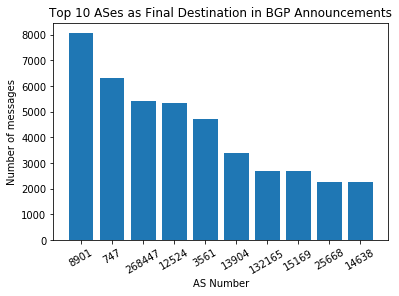

In [7]:
fig, ax = plt.subplots()

chart = ax.bar([str(a[0]) for a in as_counts[:10]], [a[1] for a in as_counts[:10]])
plt.xticks(rotation=30)
ax.set_xlabel('AS Number')
ax.set_ylabel('Number of messages')
ax.set_title('Top 10 ASes as Final Destination in BGP Announcements')

plt.show()

We can use the `whois` command to see what routes are attributed to a particular AS. Let's take a look at that for the most popular selection...

In [8]:
# Only run the following if we have whois/grep built-in...
if sys.platform in ['linux', 'darwin']:
    !whois -h whois.radb.net -- -i origin AS{as_counts[0][0]} | grep 'descr:\|route:'
else:
    print('Running Windows, skipping...')

route:          212.11.128.0/19
descr:          Moscow Mayor's Office
route:          212.11.128.0/21
descr:          Moscow Mayor's Office
route:          212.11.136.0/21
descr:          Moscow Mayor's Office
route:          212.11.144.0/21
descr:          Moscow Mayor's Office
route:          212.11.152.0/21
descr:          Moscow Mayor's Office
route:          185.173.0.0/24
descr:          COD-KR-1
route:          185.173.1.0/24
descr:          COD-KR-2
route:          185.173.3.0/24
descr:          COD-KR-4
route:          185.173.0.0/22
descr:          COD-KR
route:          178.208.149.0/24


>Moscow Mayor's Office

Interesting, interesting...

### Bringing Prefixes into the Mix
We have determined that the number of unique final-destination AS numbers is significantly less than the total number of messages broadcast/propagated for any time period. How does the number of unique prefixes compare?

Recall that the BGP4 specification allows for multiple prefix announcements to come in a single message, assuming that they belong to the relevant final-destination AS on the `AS_PATH`.

In [9]:
all_prefixes = []
for message in all_announcements:
    all_prefixes.extend([m.get('prefix') for m in message.get('bgp_update').get('advertized_routes')])
unique_prefixes = set(all_prefixes)
print('Total number of prefixes from all announcements: {:d}'.format(len(all_prefixes)))
print('Number of unique prefixes from all announcements: {:d}'.format(len(unique_prefixes)))

Total number of prefixes from all announcements: 692127
Number of unique prefixes from all announcements: 30045


What if we also bring the prefix mask into account?

In [10]:
all_pf_masks = []
for message in all_announcements:
    all_pf_masks.extend([(m.get('prefix'), m.get('mask')) for m in message.get('bgp_update').get('advertized_routes')])
unique_pf_masks = set(all_pf_masks)
print('Number of unique prefixes and masks from all announcements: {:d}'.format(len(unique_pf_masks)))

Number of unique prefixes and masks from all announcements: 31357


Very intersting... This appears to make only a small difference, on the order of 5% or less. Still, prefixes of different mask lengths should be considered unique, as they are in routing.

Let's combine all of the above unique characteristics by defining a utility function to create unique tuples of (`prefix`, `mask`, `AS_Destination`):

In [11]:
def get_composite_keys(messages):
    """Get tuples containing components of BGP message composite key. Namely,
    the prefix, the mask, and the destination AS number for each message, with
    duplicates removed (i.e., a set).
    Args:
    messages (list of dict): The list of messages for which to create the set
        of composite keys.
    Returns: A set containing such composite keys.
    """
    ret_set = set()
    for m in messages:
        destination = m.get('bgp_update').get('attrs').get('as_path')[-1].get('as_seq')[-1]
        composite_key = [(destination, r.get('prefix'), r.get('mask')) for r in m.get('bgp_update').get('advertized_routes')]
        ret_set.update(composite_key)
    return ret_set

In [12]:
unique_composites = get_composite_keys(all_announcements)
print('Total number of unique prefix, mask, and AS destination triplets: {:d}'.format(len(unique_composites)))

Total number of unique prefix, mask, and AS destination triplets: 31428


This is especially interesting, as it reveals that including the prefix and mask in such a composite key still raises the number of "unique" messages, but only by a small amount. This function will come in handy later.

**An important note:** With this extraction of prefixes, it may be possible to end up with more "unique" messages than original messages, as the BGP4 specification allows for a single BGP announcement to advertise more than one prefix. That is, this method considers a message that advertises two unique prefixes as two unique messages.

## Experimenting with the Temporal Side of Data
Let's now investigate how putting different messages into different time-interval "buckets" results in different numbers of these unique (prefix, mask, AS number) tuples. Note that the timestamps on each BGP message are marked only down to the second.

First off, how many unique timestamps are there, what's their range?

In [13]:
times = [dt.strptime(single.get('mrt_header').get('timestamp'),
                     '%Y-%m-%dT%H:%M:%S%z') for single in all_announcements]

In [14]:
times.sort(key=lambda t: t.timestamp())
unique_times = set(times)
print('There are {:d} unique timestamps'.format(len(unique_times)))
print('First time:')
print(times[0])
print('Last time:')
print(times[-1])

There are 2149 unique timestamps
First time:
2018-10-31 18:00:00-06:00
Last time:
2018-10-31 19:00:00-06:00


### Breaking into Buckets
Let's now divide up the announcements into different "buckets" of time, where each bucket is of the same time interval in seconds.

In [15]:
def create_buckets(interval, messages):
    """Create a number of time period 'buckets' during each of which BGP messages occurred.
    Args:
    interval (int): The interval at which to split buckets, in seconds.
    messages (list of dict): The messages to organize.
    Returns:
    A dict with the appropriate number of buckets and all messages inside each bucket.
    """
    # First retrieve times and sort them
    times = [dt.strptime(
        single.get('mrt_header').get('timestamp'),
        '%Y-%m-%dT%H:%M:%S%z') for single in messages]
    times.sort(key=lambda t: t.timestamp())
    
    # Assemble buckets
    start_time = times[0].timestamp()
    end_time = times[-1].timestamp()
    num_buckets = round((end_time - start_time) / interval)

    # Divide up the announcements into their proper buckets
    time_divided = {b: [] for b in range(num_buckets)}

    for m in messages:
        tstamp = dt.strptime(m.get('mrt_header').get('timestamp'), '%Y-%m-%dT%H:%M:%S%z')
        bucket = min(math.floor((tstamp.timestamp() - start_time) / interval), num_buckets - 1)
        time_divided[bucket].append(m)
    return time_divided

We also define a function to plot the number of unique messages in each time interval:

In [16]:
def plot_buckets(time_buckets, interval):
    """Plot the number of messages captured during each specified time interval.
    Args:
    time_buckets (dict): The dictionary of 'time buckets' that contains each set of
        detected messages during each bucket.
    interval (int): The actual interval of the time buckets.
    """
    bucket_lens = [len(b) for b in time_buckets.values()]
    buckets = ['{:d}-{:d}'.format((b * interval), ((b + 1) * interval)) for b in time_buckets.keys()]
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    bars = ax.bar(buckets, bucket_lens)
    # Remove x ticks if there are many data points
    if len(buckets) > 40:
        plt.tick_params(labelbottom=False)
    plt.xticks(rotation=90)
    plt.title('BGP messages divided into time buckets')
    plt.ylabel('No. of messages')
    plt.xlabel('Time bucket (intervals of seconds)')
    plt.show()

Let's start with a 20 second interval and see what the general spread looks like.

In [17]:
interval = 20
td = create_buckets(interval, all_announcements)

The plot below demonstrates the distribution of messages receieved during 20 second intervals. There are clearly some set periods of downtime, as well as some interesting spikes in the number of raw messages.

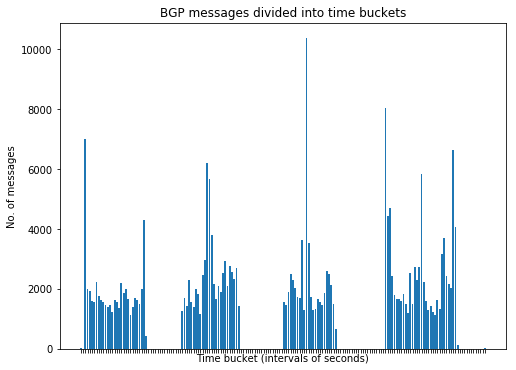

In [18]:
plot_buckets(td, interval)

Let's adjust the interval to be a bit less granular. The plot below divides the messages captured into buckets of 60 second durations. There are still clear intervals during which no messages were received (at least for this dataset/collector).

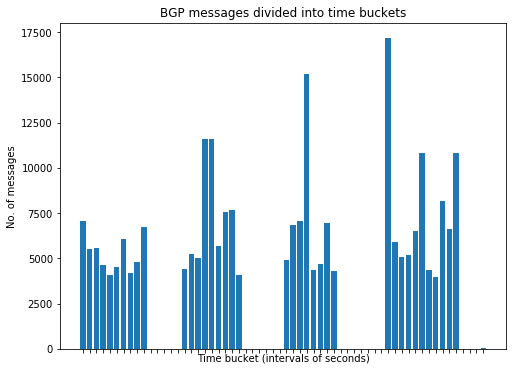

In [19]:
interval = 60
td = create_buckets(interval, all_announcements)
plot_buckets(td, interval)

### Revisiting "Unique" Destinations
What about if we change the number of total messages to the number of messages with a unique prefix/mask and final destination?

In [20]:
# Convert the current buckets to contain only the unique destinations seen during
# that time period
buckets_unique = {k: get_composite_keys(v) for (k, v) in td.items()}

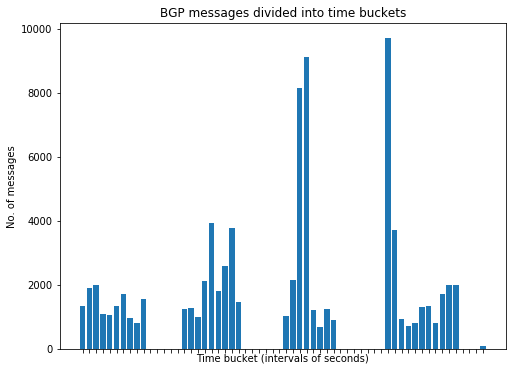

In [21]:
# Now plot this new information; function is still applicable
plot_buckets(buckets_unique, interval)

To make the difference between the number of raw messages per each time period and the number of "unique" messages (in terms of prefix, mask, and destination AS) clear, let's plot them together:

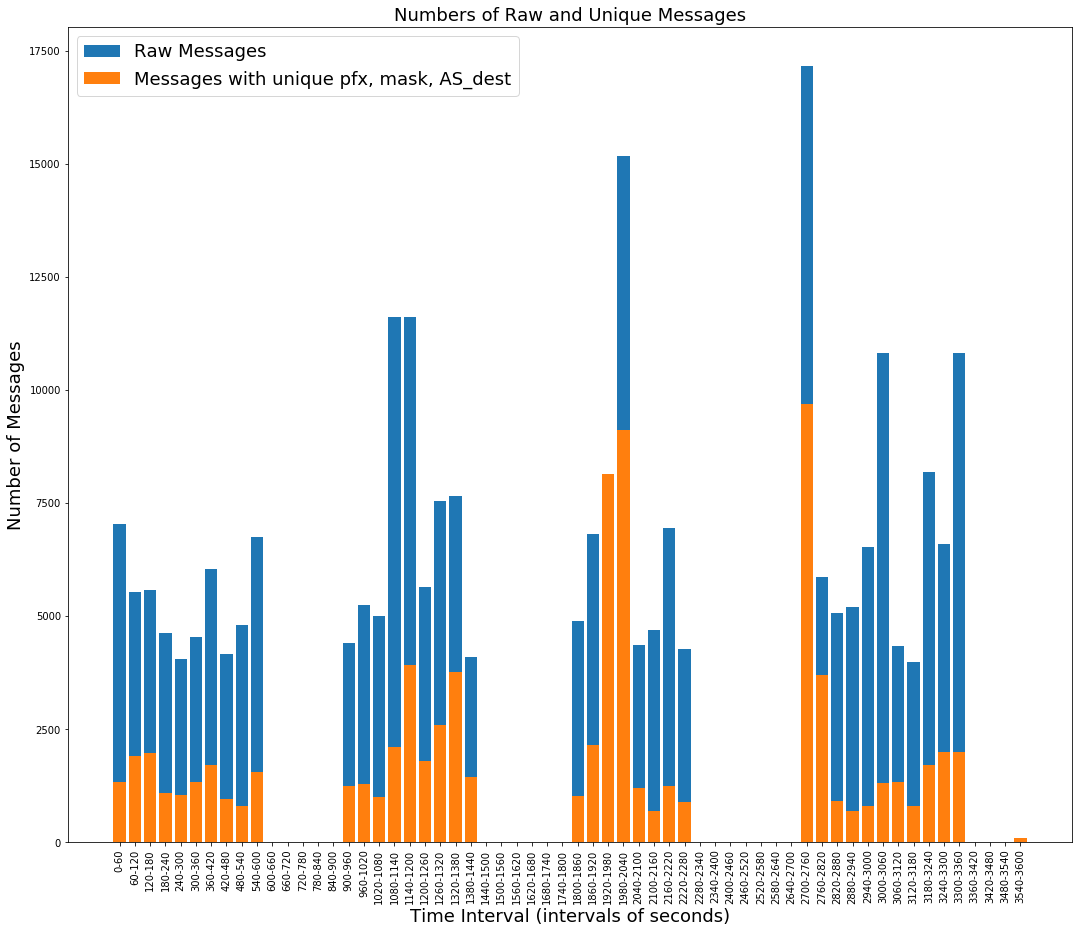

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 15)

intervals = ['{:d}-{:d}'.format(k * interval, (k + 1) * interval) for k in td.keys()]
regular_buckets = [len(b) for b in td.values()]
u_buckets = [len(b) for b in buckets_unique.values()]

r_bar = ax.bar(intervals, regular_buckets)
u_bar = ax.bar(intervals, u_buckets)

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(rotation=90)
plt.title('Numbers of Raw and Unique Messages', fontsize=18)
plt.ylabel('Number of Messages')
plt.xlabel('Time Interval (intervals of seconds)')
plt.legend((r_bar, u_bar), ('Raw Messages', 'Messages with unique pfx, mask, AS_dest'), fontsize=18)
plt.show()

Clearly, there is quite a variety of how many of these "unique" messages appear during each time period, and how they compare to the raw number of messages. Note the average proportion of "unique" messages to raw messages:

In [23]:
proportions = [len(b) / len(a) if len(b) > 0 else 0 for (a, b) in zip(td.values(), buckets_unique.values())]
statistics.mean(proportions)

0.22988148258158747

### Some Thoughts
Recall that it is possible for the number of "unique" messages to be greater than the actual number of messages, as the BGP4 specification allows for one message to advertise one or many prefix/mask combinations. Therefore, it is possible that one message actually contains several unique pieces of information.

Now, how much impact does this temporal difference really have on the different messages? How many of the "time buckets" does each "unique" message span? Using our previously calculated example, let's find out:

In [24]:
intervals_per_message = [[1 if c in b else 0 for b in buckets_unique.values()] for c in unique_composites]
appearances = [sum(t) for t in intervals_per_message]
print('Average number of time intervals for each message: {:f}'.format(statistics.mean(appearances)))
print('Standard deviation of number of time intervals for each message: {:f}'.format(statistics.stdev(appearances)))
print('Maximum number of appearances for any one message: {:d}'.format(max(appearances)))
print('Mode number of appearances for any one message: {:d}'.format(statistics.mode(appearances)))

Average number of time intervals for each message: 2.623839
Standard deviation of number of time intervals for each message: 3.743804
Maximum number of appearances for any one message: 39
Mode number of appearances for any one message: 1


On average, each unique message is found in about 2.6 buckets; perhaps a different time interval should be considered for this reason... However, the mode is 1 bucket per message, as might be expected, and the standard deviation of 3.74 suggests that this data is reasonably clustered around the mean, indicating that not many messages span a great amount of time, at least for this data set.